Hello, and welcome! This is the notebook for calulating the skull thickness and scalp-to-cortoex distance map, as well as the brain volume. Let's do it!
We use open3d for distance calculation and pyvista for volume calculation. So pip install them if you haven't done so.


In [1]:
import open3d as o3d
import numpy as np
import os
import fnmatch
import dicom2nifti
import pyvista as pv

import csv

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


This function enables interaction visualization of point clouds in open3d, so you can pick points with your mouse in the visualization window.

In [99]:
def pick_points(pcd):
    print("")
    print(
        "1) Please pick at least three correspondences using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) Afther picking points, press q for close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

Don't worry about this if you are using your own dataset. If you are look at this, you should be fimiliar with Python and know how to sort system files.

In [100]:
age_path = 'updated_ANDI'

In [101]:
roots = []
for root, dirs, files in os.walk(age_path):
    for file in files:
        if file.endswith('.obj'):
            roots += [root]
            break

In [102]:
# check if the id is captured
print(roots[-4][13:23])

941_S_6581


In [110]:
full_ids = []
for root in roots:
    full_ids += [root[13:23]]

use .compute_cell_sizes from pyvista to compute mesh volumes

In [116]:
cell_volumes = []
for result_id in my_results_ids:
    outer_mesh = pv.read(roots[full_ids.index(result_id)]+"\\cortex.obj")
    sized = outer_mesh.compute_cell_sizes()
    cell_volume = sized.cell_data["Volume"]
    cell_volumes += [cell_volume]

pyvista_ndarray([0., 0., 0., ..., 0., 0., 0.])

In [125]:
volume_list = []
for cell in cell_volumes:
    volume = len(cell)
    volume_list.append(volume)

In [130]:
volume_result = pd.DataFrame(data = volume_predict)
volume_result.to_csv('Volume_predict.csv', index=False)

In [49]:
n = 0

outer_mesh = o3d.io.read_triangle_mesh(roots[n]+"\\cortex.obj")
#inner_mesh = o3d.io.read_triangle_mesh(roots[n]+"\\scalp.obj")

o3d.visualization.draw_geometries([outer_mesh])


The following function performs distance calculation. You need to pick a point with mouse and it will show the distance.

In [37]:
n = 0

In [48]:


outer_mesh = o3d.io.read_triangle_mesh(roots[n]+"\\scalp.obj")
inner_mesh = o3d.io.read_triangle_mesh(roots[n]+"\\cortex.obj")


outer_mesh.compute_vertex_normals()
outer_pcd = outer_mesh.sample_points_uniformly(number_of_points=500000)
outer_pcd.paint_uniform_color([1, 0.706, 0])

inner_mesh.compute_vertex_normals()
inner_pcd = inner_mesh.sample_points_uniformly(number_of_points=500000)

inner_tree = o3d.geometry.KDTreeFlann(inner_pcd)
dists = []
for i in range(len(outer_pcd.points)):
    [k, idx, _] = inner_tree.search_knn_vector_3d(outer_pcd.points[i], 5)
    dist = np.mean(np.linalg.norm(np.asarray(inner_pcd.points)[np.asarray(idx)] - outer_pcd.points[i], axis = 1))
    if dist < 8:
        dist = 8
    elif dist > 18:
        dist = 18
    dists += [dist]
dists = (np.asarray(dists)-min(dists))/(max(dists)-min(dists))

for i in range(len(outer_pcd.points)):
    if dists[i] <= 32/256:
        r = 0
        g = 0
        b = 0.5 + 0.5*(dists[i]-0)/(32/256)
    elif 32/256 * 1 < dists[i] <= 32/256 * 3:
        r = 0
        g = (dists[i] - 32/256)/(32/256) * 0.5
        b = 1
    elif 32/256 * 3 < dists[i] <= 32/256 * 5:
        r = (dists[i] - 3*32/256)/(32/256) * 0.5
        g = 1
        b = 1 - r
    elif 32/256 * 5 < dists[i] <= 32/256 * 7:
        r = 1
        g = (7*32/256 - dists[i])/(32/256) * 0.5
        b = 0
    else:
        r = (8*32/256 - dists[i])/(32/256) * 0.5
        g = 0
        b = 0
    np.asarray(outer_pcd.colors)[i, :] = [r, g, b]
    
results = pick_points(outer_pcd)
for result in results:
    print(8+18*dists[result])
print(n)



1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) Afther picking points, press q for close the window

28


In [47]:
_list = [roots[n][13:23]]
for result in results:
    _list.append(1+10*dists[result])

 
file = open('results_08_12_2022_SCD.csv', 'a', newline ='')
with file:
    # identifying header 
    header = ['ID', 'Gender', 'Age', 'Sphenoid_bone', 'Temporal_bone', 'Parietal_bone', 'Occipital_bone']
    writer = csv.DictWriter(file, fieldnames = header)
    #writer.writeheader()
    writer.writerow({'ID' : _list[0],
                     'Sphenoid_bone': _list[1],
                     'Temporal_bone': _list[2],
                     'Parietal_bone': _list[3],
                     'Occipital_bone': _list[4]})
n += 1

A helper to make colorbar

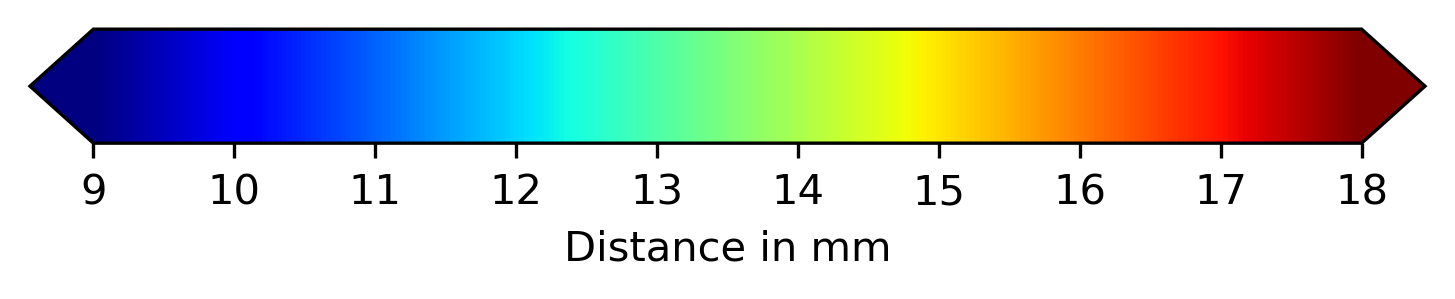

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=9, vmax=18)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Distance in mm', extend = 'both')

fig.savefig('SCD_colorbar')

In [22]:
outer = o3d.io.read_point_cloud('outer.ply')
inner = o3d.io.read_point_cloud('inner.ply')

In [12]:
pick_points(outer)


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) Afther picking points, press q for close the window
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 



[]

In [23]:
outer.paint_uniform_color([.5, .5, .5])
inner.paint_uniform_color([.5, .5, .5])

PointCloud with 5462 points.

In [10]:
phantom = pv.read("SKULL FINAL.stl")
vessel = pv.read("Stroke Vessels FINAl copped_more.stl")


p = pv.Plotter()
p.add_mesh(phantom,
           color = [0.3, 0.3, 0.3],
            opacity = 0.4)
p.add_mesh(vessel, color = 'r')
p.set_background('white')
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [8]:
test_path = "\\updated_ANDI\\012_S_4642\\MPRAGE_SENSE2\\2012-04-10_14_38_38.0\\I296876"
from pathlib import Path
p = Path(test_path + '\\scalp.wfo')
p.rename(p.with_suffix('.obj'))

WindowsPath('/updated_ANDI/012_S_4642/MPRAGE_SENSE2/2012-04-10_14_38_38.0/I296876/scalp.obj')